# Import Data and Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import sklearn
import string
import re
import os
import time

from nltk import pos_tag
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from emoji import UNICODE_EMOJI
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Perceptron, SGDClassifier, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.decomposition import TruncatedSVD
from textblob import TextBlob
from sklearn.neighbors import KNeighborsClassifier

os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"

In [2]:
# Read in the data and investigate the first 5 rows
tweet_df = pd.read_csv('congressional_tweet_training_data.csv')
party_id = tweet_df['party_id'].tolist()
tweet_df.head(5)

,favorite_count,full_text,hashtags,retweet_count,year,party_id
0,0,"b""RT @KUSINews: One of our longtime viewers wa...",KUSI,10,2017.0,R
1,258,"b""Today I'm urging the @CDCgov to immediately ...",Coronavirus,111,2020.0,R
2,0,"b'Tomorrow, #MO03 seniors graduate from Calvar...",MO03,2,2014.0,R
3,9,b'Congrats to #TeamUSA and Canton Native @JGre...,TeamUSA WorldJuniors,3,2017.0,R
4,3,b'Pleased to support @amergateways at their Ju...,ImmigrantHeritageMonth,3,2019.0,D


In [3]:
# Helper function to label the part of speech
def get_pos_tag(word_tag_tuple_list):
    tag_list = []
    for t in word_tag_tuple_list:
        tag_first_letter = t[1][0].upper()
        if tag_first_letter == "N":
            tag_list.append(wordnet.NOUN)
        elif tag_first_letter == "V":
            tag_list.append(wordnet.VERB)
        elif tag_first_letter == "J":
            tag_list.append(wordnet.ADJ)
        elif tag_first_letter == "R":
            tag_list.append(wordnet.ADV)
        else:
            tag_list.append(None)
    return tag_list

In [4]:
# Text preprocessing and save the processed dataset to a file (since preprocessing take much time)
def preprocess(df, file_name):
    ps = PorterStemmer()
    text_list = df['full_text'].tolist()
    temp = [text.lower()[2:-1] for text in text_list]
    df['text1'] = temp
    # Tokenize
    df['text_tokenized'] = df['text1'].apply(word_tokenize)
    # POS Tag
    df['text_postagged'] = df['text_tokenized'].apply(pos_tag)
    # Lemmatization
    text_list = df['text_postagged'].tolist()
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = []
    for text in text_list:
        tag_list = get_pos_tag(text)
        temp_list = []
        for i in range(len(text)):
            if tag_list[i] is not None:
                temp_list.append(lemmatizer.lemmatize(text[i][0], tag_list[i]))
            else:
                temp_list.append(text[i][0])
        lemmatized_text.append(temp_list)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    no_stopword_text = []
    for text in lemmatized_text:
        temp = []
        for word in text:
            if word not in stop_words:
                temp.append(word)
        no_stopword_text.append(temp)
    final_text_temp = []
    for text in no_stopword_text:
        temp = []
        for word in text:
            # The following code could be merged into a single if statement using OR. 
            # I choose to write it in this way for clarity. 
            # Remove words shorter than 2 characters
            if len(word) < 2:
                continue
            if word.startswith('@'):
                continue
            # Remove punctuations
            if word in string.punctuation:
                continue
            # Remove emoji [1]
            if word in UNICODE_EMOJI or word.startswith('\\'):
                continue
            # Remove link:
            if word.startswith('http') or word.startswith('www'):
                continue
            # Remove numbers:
            if word.isdecimal():
                continue
            # Remove retweet:
            if word == 'rt':
                continue
            temp.append(word)
        final_text_temp.append(temp)
    # Convert words back into a joined string
    final_text = [" ".join(l) for l in final_text_temp]
    df['text_clean'] = final_text
    # tweet_df.drop(['text_tokenized', 'text_postagged'], axis=1, inplace=True)
    df.to_csv(file_name)
    return df

In [5]:
preprocess(tweet_df, 'tweet_clean.csv')

,favorite_count,full_text,hashtags,retweet_count,year,party_id,text1,text_tokenized,text_postagged,text_clean
0,0,"b""RT @KUSINews: One of our longtime viewers wa...",KUSI,10,2017.0,R,rt @kusinews: one of our longtime viewers was ...,"[rt, @, kusinews, :, one, of, our, longtime, v...","[(rt, NN), (@, JJ), (kusinews, NNS), (:, :), (...",kusinews one longtime viewer congressman darre...
1,258,"b""Today I'm urging the @CDCgov to immediately ...",Coronavirus,111,2020.0,R,today i'm urging the @cdcgov to immediately la...,"[today, i, 'm, urging, the, @, cdcgov, to, imm...","[(today, NN), (i, VBP), ('m, VBP), (urging, VB...",today 'm urge cdcgov immediately launch 24/7 p...
2,0,"b'Tomorrow, #MO03 seniors graduate from Calvar...",MO03,2,2014.0,R,"tomorrow, #mo03 seniors graduate from calvary ...","[tomorrow, ,, #, mo03, seniors, graduate, from...","[(tomorrow, NN), (,, ,), (#, #), (mo03, JJ), (...",tomorrow mo03 senior graduate calvary lutheran...
3,9,b'Congrats to #TeamUSA and Canton Native @JGre...,TeamUSA WorldJuniors,3,2017.0,R,congrats to #teamusa and canton native @jgreen...,"[congrats, to, #, teamusa, and, canton, native...","[(congrats, NNS), (to, TO), (#, #), (teamusa, ...",congrats teamusa canton native jgreenway12 win...
4,3,b'Pleased to support @amergateways at their Ju...,ImmigrantHeritageMonth,3,2019.0,D,pleased to support @amergateways at their june...,"[pleased, to, support, @, amergateways, at, th...","[(pleased, JJ), (to, TO), (support, VB), (@, N...",pleased support amergateways june fiesta honor...
...,...,...,...,...,...,...,...,...,...,...
592798,3,"b'This time, it focused on careers in #publics...",publicservice publicsafety,0,2017.0,R,"this time, it focused on careers in #publicser...","[this, time, ,, it, focused, on, careers, in, ...","[(this, DT), (time, NN), (,, ,), (it, PRP), (f...",time focus career publicservice publicsafety /...
592799,5,"b'.#StormyDaniels, #MichaelWolfe, #JamesComey ...",StormyDaniels MichaelWolfe JamesComey,1,2018.0,R,".#stormydaniels, #michaelwolfe, #jamescomey ma...","[., #, stormydaniels, ,, #, michaelwolfe, ,, #...","[(., .), (#, #), (stormydaniels, NNS), (,, ,),...",stormydaniels michaelwolfe jamescomey make fbi...
592800,33,b'@NRDems The American people deserve the trut...,CultureOfCorruption,14,2020.0,D,@nrdems the american people deserve the truth ...,"[@, nrdems, the, american, people, deserve, th...","[(@, NN), (nrdems, VBZ), (the, DT), (american,...",nrdems american people deserve truth congress ...
592801,4,b'Only 2 weeks left to submit your #app to the...,app copolitics CAC16 HouseOfCode co06,3,2016.0,R,only 2 weeks left to submit your #app to the c...,"[only, 2, weeks, left, to, submit, your, #, ap...","[(only, RB), (2, CD), (weeks, NNS), (left, VBD...",week leave submit app congressional app challe...


# Descriptive Analysis

## Temporal Analysis on Favorite Count and Retweet Count

In [6]:
# Average favorate counts and retweet count per year for the two parties
df1 = tweet_df.groupby(['year','party_id']).mean()
df1 = df1.reset_index()
df1

,year,party_id,favorite_count,retweet_count
0,2008.0,R,0.076923,0.000000
1,2009.0,D,0.042042,0.261261
2,2009.0,R,0.121331,0.172211
3,2010.0,D,0.262255,6.779412
4,2010.0,R,0.078713,1.151266
5,2011.0,D,0.266780,5.040886
6,2011.0,R,0.080273,1.767509
7,2012.0,D,1.197871,8.800384
8,2012.0,R,0.626997,5.422889
9,2013.0,D,2.008755,17.119956


<AxesSubplot:xlabel='year'>

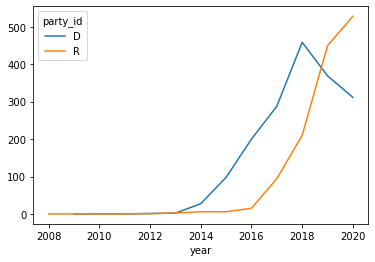

In [7]:
# Make the plot for favorite count
df2 = df1.drop(['retweet_count'], axis=1, inplace=False)
df2 = df2.pivot(index='year', columns='party_id', values='favorite_count')
df2.plot()

<AxesSubplot:xlabel='year'>

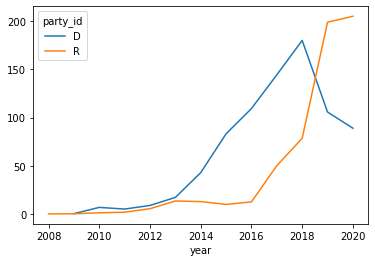

In [8]:
# Make the plot for retweet count
df3 = df1.drop(['favorite_count'], axis=1, inplace=False)
df3 = df3.pivot(index='year', columns='party_id', values='retweet_count')
df3.plot()

## Hashtag Frequency

In [9]:
# Convert hashtag to lower case
tweet_df['hashtags'] = tweet_df['hashtags'].str.lower()
tweet_df.groupby(['party_id', 'hashtags']).count().sort_values(['favorite_count'], ascending=False).head(10)

favorite_count  full_text  retweet_count  year  \
party_id hashtags                                                         
D        covid19                   7155       7155           7155  6296   
R        obamacare                 3789       3789           3789  3788   
         taxreform                 3435       3435           3435  3435   
         covid19                   2930       2930           2930  2610   
         sotu                      2902       2902           2902  2902   
D        goptaxscam                2862       2862           2862  2862   
         trumpcare                 2481       2481           2481  2481   
         forthepeople              2056       2056           2056  1889   
         protectourcare            1948       1948           1948  1928   
         sotu                      1927       1927           1927  1927   

                         text1  text_tokenized  text_postagged  text_clean  
party_id hashtags                                                           
D        covid19          7155            7155            7155        7155  
R        obamacare        3789            3789            3789        3789  
         taxreform        3435            3435            3435        3435  
         covid19          2930            2930            2930        2930  
         sotu             2902            2902            2902        2902  
D        goptaxscam       2862            2862            2862        2862  
         trumpcare        2481            2481            2481        2481  
         forthepeople     2056            2056            2056        2056  
         protectourcare   1948            1948            1948        1948  
         sotu             1927            1927            1927        1927

In [10]:
totaldf = tweet_df.hashtags.value_counts().head(10)
df_value_counts = pd.DataFrame(totaldf)
df_value_counts = df_value_counts.reset_index()
df_value_counts.columns = ['hashtags', 'counts']
df_value_counts

,hashtags,counts
0,covid19,10085
1,sotu,4829
2,obamacare,3975
3,taxreform,3618
4,coronavirus,3300
5,goptaxscam,2863
6,trumpcare,2481
7,forthepeople,2057
8,utpol,1951
9,protectourcare,1948


In [11]:
D_list = []
R_list = []
for ele in df_value_counts['hashtags']:
    R_length = len(tweet_df[(tweet_df['hashtags']==ele) & (tweet_df['party_id']=='R')])
    D_length = len(tweet_df[(tweet_df['hashtags']==ele) & (tweet_df['party_id']=='D')])
    
    D_list.append(D_length)
    R_list.append(R_length)

<AxesSubplot:title={'center':'Stacked Bar Graph'}, xlabel='hashtags'>

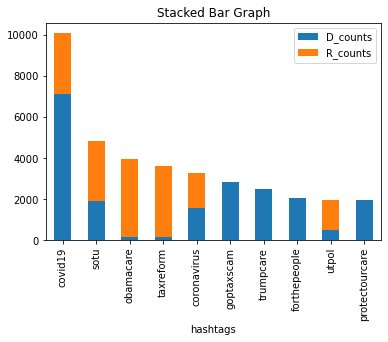

In [12]:
df_value_counts['D_counts'] = D_list #Calculate the Ratio of 
df_value_counts['R_counts'] = R_list
df_value_counts.drop(['counts'],axis = 1, inplace = True)
df_value_counts.plot(x='hashtags', kind='bar', stacked=True, title='Stacked Bar Graph')

## Sentiment Analysis

In [13]:
# Sentiment Analysis
def senti_analysis(x):
    return TextBlob(x).sentiment

tweet_df['senti_score_t'] = tweet_df['text_clean'].apply(senti_analysis)

senti_score = []
senti_score_tuple = tweet_df['senti_score_t'].tolist()
for t in senti_score_tuple:
    senti_score.append(t[0])
tweet_df['senti_score'] = senti_score
tweet_df.head(5)

,favorite_count,full_text,hashtags,retweet_count,year,party_id,text1,text_tokenized,text_postagged,text_clean,senti_score_t,senti_score
0,0,"b""RT @KUSINews: One of our longtime viewers wa...",kusi,10,2017.0,R,rt @kusinews: one of our longtime viewers was ...,"[rt, @, kusinews, :, one, of, our, longtime, v...","[(rt, NN), (@, JJ), (kusinews, NNS), (:, :), (...",kusinews one longtime viewer congressman darre...,"(1.0, 1.0)",1.000000
1,258,"b""Today I'm urging the @CDCgov to immediately ...",coronavirus,111,2020.0,R,today i'm urging the @cdcgov to immediately la...,"[today, i, 'm, urging, the, @, cdcgov, to, imm...","[(today, NN), (i, VBP), ('m, VBP), (urging, VB...",today 'm urge cdcgov immediately launch 24/7 p...,"(0.0, 0.025641025641025644)",0.000000
2,0,"b'Tomorrow, #MO03 seniors graduate from Calvar...",mo03,2,2014.0,R,"tomorrow, #mo03 seniors graduate from calvary ...","[tomorrow, ,, #, mo03, seniors, graduate, from...","[(tomorrow, NN), (,, ,), (#, #), (mo03, JJ), (...",tomorrow mo03 senior graduate calvary lutheran...,"(0.0, 0.0)",0.000000
3,9,b'Congrats to #TeamUSA and Canton Native @JGre...,teamusa worldjuniors,3,2017.0,R,congrats to #teamusa and canton native @jgreen...,"[congrats, to, #, teamusa, and, canton, native...","[(congrats, NNS), (to, TO), (#, #), (teamusa, ...",congrats teamusa canton native jgreenway12 win...,"(0.4, 0.23333333333333334)",0.400000
4,3,b'Pleased to support @amergateways at their Ju...,immigrantheritagemonth,3,2019.0,D,pleased to support @amergateways at their june...,"[pleased, to, support, @, amergateways, at, th...","[(pleased, JJ), (to, TO), (support, VB), (@, N...",pleased support amergateways june fiesta honor...,"(0.21666666666666665, 0.5750000000000001)",0.216667


<AxesSubplot:>

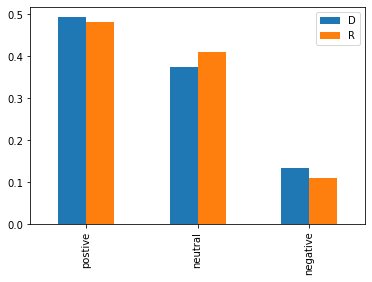

In [14]:
# Make the bar chart
positive_r = len(tweet_df[(tweet_df['party_id'] == 'R') & (tweet_df['senti_score'] >= 0.05)]) / len(tweet_df[tweet_df['party_id'] == 'R'])
negative_r = len(tweet_df[(tweet_df['party_id'] == 'R') & (tweet_df['senti_score'] <= -0.05)]) / len(tweet_df[tweet_df['party_id'] == 'R'])
neutral_r = 1 - positive_r - negative_r

positive_d = len(tweet_df[(tweet_df['party_id'] == 'D') & (tweet_df['senti_score'] >= 0.05)]) / len(tweet_df[tweet_df['party_id'] == 'D'])
negative_d = len(tweet_df[(tweet_df['party_id'] == 'D') & (tweet_df['senti_score'] <= -0.05)]) / len(tweet_df[tweet_df['party_id'] == 'D'])
neutral_d = 1 - positive_d - negative_d 

sentiment_df = pd.DataFrame({'R': [positive_r, neutral_r, negative_r], 'D': [positive_d, neutral_d, negative_d]})
sentiment_df.index = ['postive', 'neutral', 'negative']
sentiment_df.plot(y=['D', 'R'], kind='bar')

# Train Predictive Model

In [15]:
# Vectorizing and Creating the Feature Space
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# TfidfVectorizer
t_vectorizer1 = TfidfVectorizer(ngram_range=(1, 1), max_features = 114000, lowercase=True)
t_vector1 = t_vectorizer1.fit_transform(tweet_df['text_clean'])

In [16]:
# Dummy the Target Variable
party_label = []
for party in party_id:
    if party == 'R':
        party_label.append(0)
    else:
        party_label.append(1)
tweet_df['party_id_num'] = party_label

In [17]:
# Helper function to set up the model
def train_model(x, y):
    classifier = RidgeClassifier()
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.999, test_size=0.001, random_state=265)
    model = classifier.fit(x_train, y_train)
    accuracy1 = model.score(x_train, y_train)
    accuracy2 = model.score(x_test, y_test)
    print(f'The training accuracy is {accuracy1}')
    print(f'The testing accuracy is {accuracy2}')
    print(pd.crosstab(model.predict(x_test), y_test, rownames=['Predicted'], colnames=['Actual']))
    return model

In [18]:
# Train the Model
model = train_model(t_vector1, tweet_df['party_id_num'].to_numpy())

The training accuracy is 0.9186234612721839
The testing accuracy is 0.893760539629005
Actual       0    1
Predicted          
0          228   31
1           32  302


## Attached: Finding the Best Vectorizing Parameter for the Model Above

Using 10000 for max_features...
Using 15000 for max_features...
Using 20000 for max_features...
Using 25000 for max_features...
Using 30000 for max_features...
Using 35000 for max_features...
Using 40000 for max_features...
Using 45000 for max_features...
Using 50000 for max_features...
Using 55000 for max_features...
Using 60000 for max_features...
Using 65000 for max_features...
Using 70000 for max_features...
Using 75000 for max_features...
Using 80000 for max_features...
Using 85000 for max_features...
Using 90000 for max_features...
Using 95000 for max_features...
Using 100000 for max_features...
Using 105000 for max_features...
Using 110000 for max_features...
Using 115000 for max_features...
Using 120000 for max_features...
Using 125000 for max_features...
Using 130000 for max_features...
Using 135000 for max_features...
Using 140000 for max_features...
Using 145000 for max_features...
Using 150000 for max_features...
Using 155000 for max_features...
Using 160000 for max_feature

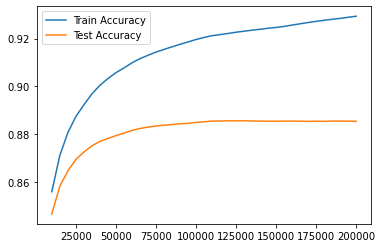

In [19]:
def model_tuning(max_features, df, train_acc, test_acc):
    t_vectorizer1 = TfidfVectorizer(ngram_range=(1, 1), max_features = max_features, lowercase=True)
    t_vector1 = t_vectorizer1.fit_transform(df['text_clean'])
    
    party_id = df['party_id'].tolist()
    party_label = []
    for party in party_id:
        if party == 'R':
            party_label.append(0)
        else:
            party_label.append(1)
    df['party_id_num'] = party_label
    
    classifier = RidgeClassifier()
    x_train, x_test, y_train, y_test = train_test_split(t_vector1, df['party_id_num'].to_numpy(), train_size=0.7, test_size=0.3, random_state=265)
    model = classifier.fit(x_train, y_train)
    accuracy1 = model.score(x_train, y_train)
    accuracy2 = model.score(x_test, y_test)
    train_acc.append(accuracy1)
    test_acc.append(accuracy2)

train_acc, test_acc = [], []
for i in range(10000, 200001, 5000):
    print(f'Using {i} for max_features...')
    model_tuning(i, tweet_df, train_acc, test_acc)
    

import matplotlib.pyplot as plt
feature_num = list(range(10000, 200001, 5000))
plt.plot(feature_num, train_acc, label='Train Accuracy')
plt.plot(feature_num, test_acc, label='Test Accuracy')
plt.legend()
plt.show()

# Prediction Submission

In [20]:
# Read in the data and preprocess
test_df = pd.read_csv('congressional_tweet_test_data.csv')
test_df = preprocess(test_df, 'tweet_clean_test.csv')

In [21]:
# Vectorize, Predict, and Label
t_vector1_test = t_vectorizer1.transform(test_df['text_clean'])
y_pred = model.predict(t_vector1_test)
party_list = []
for i in y_pred:
    if i == 0:
        party_list.append('R')
    else:
        party_list.append('D')

In [22]:
# Write to the submission file
submission_df = pd.read_csv('sample_submission.csv')
submission_df['party'] = party_list
submission_df.to_csv('sample_submission.csv', index=False)